In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
res = 32

In [3]:
# Count training and validation samples
training_N = 0
valid_N = 0
for file in os.listdir("training/"):
    label = file.split(".")[0].split("_")
    if (label[0][0:2] == "vv"): valid_N += 1
    else: training_N += 1
        
print(training_N)
print(valid_N)

1119
0


In [4]:
# This is just a copy of the simple MNIST tutorial
# https://keras.io/examples/vision/mnist_convnet/
model_terrain = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(7, 7), strides = (2, 2), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3),  activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(8, activation="softmax"),
    ]
)

model_crowns = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(7, 7), strides = (2, 2), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)


In [5]:
training_N += valid_N
noise_loops = 8

training_x= np.zeros((4*noise_loops*training_N, res, res, 3))
terrain_y = np.zeros(4*noise_loops*training_N)
crowns_y = np.zeros(4*noise_loops*training_N)

valid_x = np.zeros((valid_N, res, res, 3))
valid_terrain_y = np.zeros(valid_N)
valid_crowns_y = np.zeros(valid_N)

cntT = 0
cntV = 0
for file in os.listdir("training/"):
    tile = cv2.cvtColor(cv2.imread("training/" + file), cv2.COLOR_BGR2RGB)
    tile = cv2.resize(tile, (res, res))
    tile = tile / 255.
    label = file.split(".")[0].split("_")
    
    if label[0][0:2] == "vv":
        valid_x[cntV] = tile
        valid_terrain_y[cntV] = int(label[2])
        valid_crowns_y[cntV] = int(label[3])
        cntV = cntV + 1
    
    for k in range(4):
        training_x[cntT] = tile
        terrain_y[cntT] = int(label[2])
        crowns_y[cntT] = int(label[3])
        cntT = cntT + 1

        for j in range(noise_loops - 1):
            tmp = tile.copy()
            tmp = tmp + np.random.normal(0, 0.005, tmp.shape)
            training_x[cntT] = tmp
            terrain_y[cntT] = int(label[2])
            crowns_y[cntT] = int(label[3])
            cntT = cntT + 1

        tile = np.rot90(tile)


In [6]:
terrain_types = np.zeros(8, 'int')
for i in range(8):
    terrain_types[i] = np.sum((terrain_y == i))
print("Terrain counts: {0}".format(terrain_types))

crown_types = np.zeros(4, 'int')
for i in range(4):
    crown_types[i] = np.sum((crowns_y == i))
print("Crown types: {0}".format(crown_types))

Terrain counts: [8928 6944 5760 6272 4352 1568 1408  576]
Crown types: [25152  7808  2560   288]


In [7]:
new_idx_list = np.zeros((4*crown_types[0]), 'int')
new_idx_list[0:terrain_y.shape[0]] = np.arange(terrain_y.shape[0])
ptr = terrain_y.shape[0]

for i in range(1, 4):
    idx = np.arange(crowns_y.shape[0])
    crown_i_idxs = idx[crowns_y == i]
    resample_count = int(crown_types[0] - crown_types[i])
    resample_idxs = np.random.choice(crown_i_idxs, resample_count)
    
    new_idx_list[ptr:(ptr + resample_count)] = resample_idxs
    ptr = ptr + resample_count    
    print("We need to sample {0} more tiles w crown count {1} and we did that {2}".format(resample_count, i, resample_idxs.shape))


We need to sample 17344 more tiles w crown count 1 and we did that (17344,)
We need to sample 22592 more tiles w crown count 2 and we did that (22592,)
We need to sample 24864 more tiles w crown count 3 and we did that (24864,)


In [8]:
# Verify it worked
crown_types = np.zeros(4, 'int')
for i in range(4):
    crown_types[i] = np.sum((crowns_y[new_idx_list] == i))
print("Crown types: {0}".format(crown_types))

Crown types: [25152 25152 25152 25152]


In [9]:
# Now rebalance terrain with this new distribution
terrain_types = np.zeros(8, 'int')
for i in range(8):
    terrain_types[i] = np.sum((terrain_y[new_idx_list] == i))
print("Terrain counts: {0}".format(terrain_types))

maxT = np.max(terrain_types)
maxI = np.where(maxT == terrain_types)[0]

newer_idx_list = np.zeros((8*maxT), 'int')
newer_idx_list[0:new_idx_list.shape[0]] = np.arange(new_idx_list.shape[0])
ptr = new_idx_list.shape[0]

for i in range(8):
    if i == maxI: continue
    
    idx = np.arange( new_idx_list.shape[0] )
    terrain_i_idxs = idx[terrain_y[new_idx_list] == i]
    resample_count = int(maxT - terrain_types[i])
    resample_idxs = np.random.choice(terrain_i_idxs, resample_count)
    print("We need to sample {0} more tiles terrain type {1} and we did that {2}".format(resample_count, i, resample_idxs.shape))

    newer_idx_list[ptr:(ptr + resample_count)] = resample_idxs
    ptr = ptr + resample_count    
    

Terrain counts: [12747 11337 10083 17213 14319 32925  1408   576]
We need to sample 20178 more tiles terrain type 0 and we did that (20178,)
We need to sample 21588 more tiles terrain type 1 and we did that (21588,)
We need to sample 22842 more tiles terrain type 2 and we did that (22842,)
We need to sample 15712 more tiles terrain type 3 and we did that (15712,)
We need to sample 18606 more tiles terrain type 4 and we did that (18606,)
We need to sample 31517 more tiles terrain type 6 and we did that (31517,)
We need to sample 32349 more tiles terrain type 7 and we did that (32349,)


In [10]:
# Verify it worked
crown_types = np.zeros(4, 'int')
for i in range(4):
    crown_types[i] = np.sum((crowns_y[new_idx_list[newer_idx_list]] == i))
print("Crown types: {0}".format(crown_types))

terrain_types = np.zeros(8, 'int')
for i in range(8):
    terrain_types[i] = np.sum((terrain_y[new_idx_list[newer_idx_list]] == i))
print("Terrain counts: {0}".format(terrain_types))

Crown types: [125499  67420  45329  25152]
Terrain counts: [32925 32925 32925 32925 32925 32925 32925 32925]


In [11]:
# Restate training data into these balanced distributiions
training_x2 = training_x[new_idx_list[newer_idx_list]]
terrain_y2 = terrain_y[new_idx_list[newer_idx_list]]
crowns_y2 = crowns_y[new_idx_list[newer_idx_list]]

(4.0, 1.0)


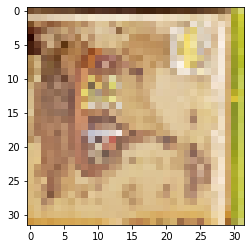

In [12]:
plt.imshow(training_x2[25000])
print((terrain_y2[25000], crowns_y2[25000]))

In [13]:
# randomly assign things to a validation set until I can get a seperate one cooked up
dims = np.arange(training_x.shape[0])
valid_N = 1000
idxs = np.random.choice(dims, valid_N)
valid_x = training_x[idxs]
valid_terrain_y = terrain_y[idxs]
valid_crowns_y = crowns_y[idxs]

# Debug Bad Training Examples Manually

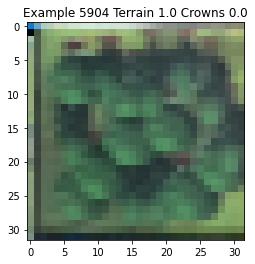

In [14]:
example = idxs[359]
example = example - 3
plt.figure()
plt.title("Example {0} Terrain {1} Crowns {2}".format(example, terrain_y[example], crowns_y[example]))
plt.imshow(training_x[example])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


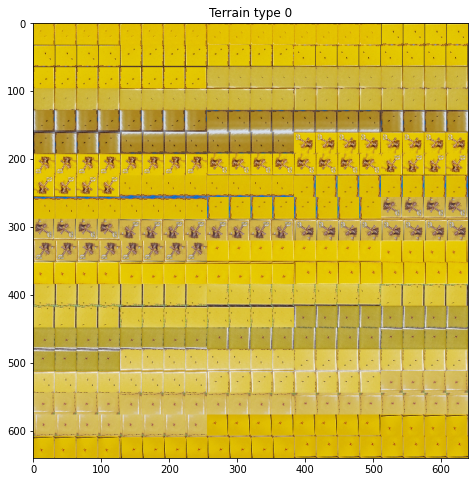

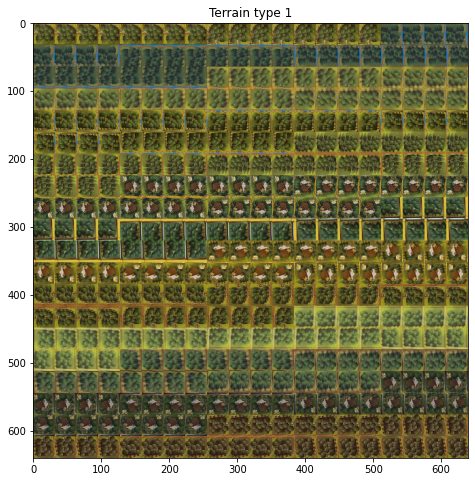

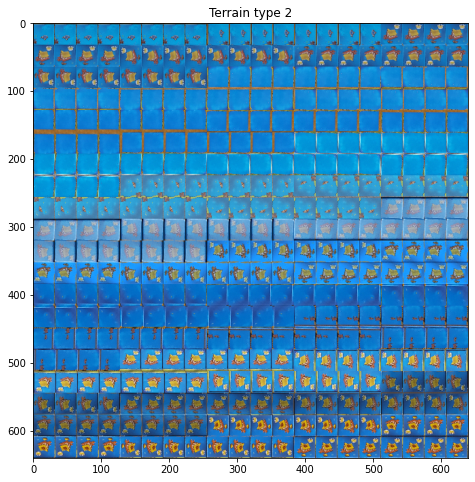

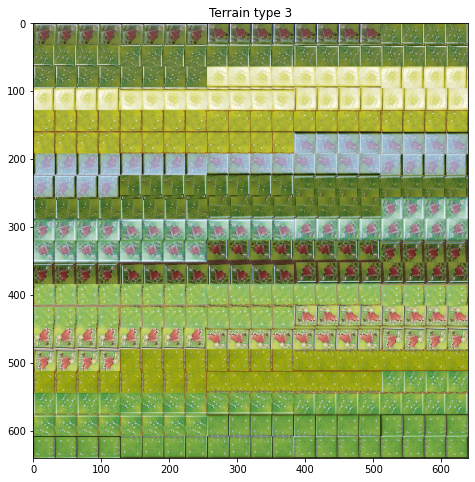

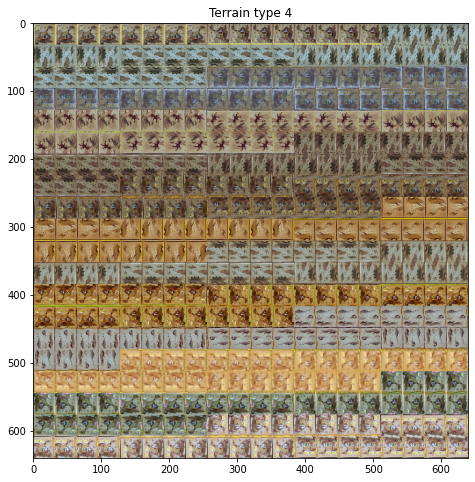

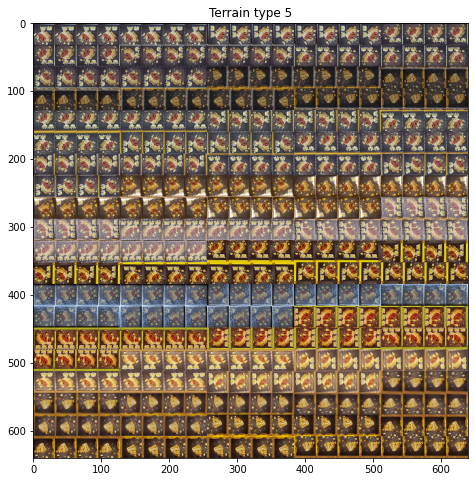

In [15]:
dim = 20
dimsq = dim*dim
big_image = np.zeros((6, dim*res, dim*res, 3))
counter = np.zeros((6), 'int')
pass_ = 400

for i in range(training_x.shape[0]):
    t = int(terrain_y[i])
    if (t > 5): continue
        
    c = counter[t]
    counter[t] += 1
    c = c - pass_
    
    if c < 0: continue
    if c >= dimsq: continue    
    
    # if t == 4 and (c // dim) == 11:
    #    print("Iteration {3}: For terrain {0} c {1} cxy {2}".format(t, c, (crow, ccol), i))
        
    
    crow = res*(c // dim)
    ccol = res*(c % dim)
    big_image[t, crow:(crow+res), ccol:(ccol+res)] = training_x[i].copy()

for i in range(6):
    plt.figure(figsize=(8, 8))
    plt.title("Terrain type {0}".format(i))
    plt.imshow(big_image[i])

# Fit models

In [16]:
model_terrain.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model_crowns.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [23]:
print("Fit model on training data")
history = model_terrain.fit(
    training_x2,
    terrain_y2,
    batch_size=1024,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(valid_x, valid_terrain_y),
)

Fit model on training data
Epoch 1/30
257/257 [==============================] - 11s 42ms/step - loss: 1.0803 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.4312 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/30
257/257 [==============================] - 10s 40ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.2286 - val_sparse_categorical_accuracy: 0.9400
Epoch 3/30
257/257 [==============================] - 10s 40ms/step - loss: 0.1982 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1408 - val_sparse_categorical_accuracy: 0.9570
Epoch 4/30
257/257 [==============================] - 10s 39ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.2850 - val_sparse_categorical_accuracy: 0.9160
Epoch 5/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.1007 - val_sparse_categorical_accuracy: 0.9690
Epoch 6/30
257/257 [==============================] - 10s 39ms/

In [24]:
score = model_terrain.evaluate(valid_x, valid_terrain_y, verbose=1)

32/32 [==============================] - 0s 2ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9980


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


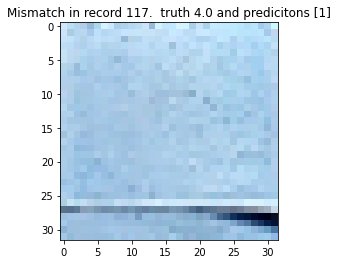

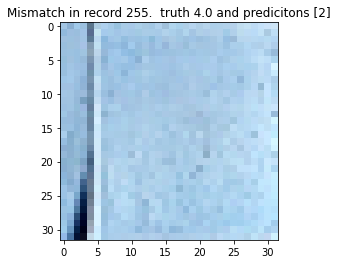

In [25]:
predictions = model_terrain.predict(valid_x)
confusion = np.zeros((8, 8))
for i in range(valid_N):
    which = np.where( predictions[i] == np.max(predictions[i]) )[0]
    confusion[int(valid_terrain_y[i]), int(which)] += 1
    if which != valid_terrain_y[i]:
        plt.figure()
        plt.title("Mismatch in record {0}.  truth {1} and predicitons {2}".format(i, valid_terrain_y[i], which))
        plt.imshow(valid_x[i])

In [26]:
confusion

array([[233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 188.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 170.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 200.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   1.,   0., 125.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  31.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  34.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  17.]])

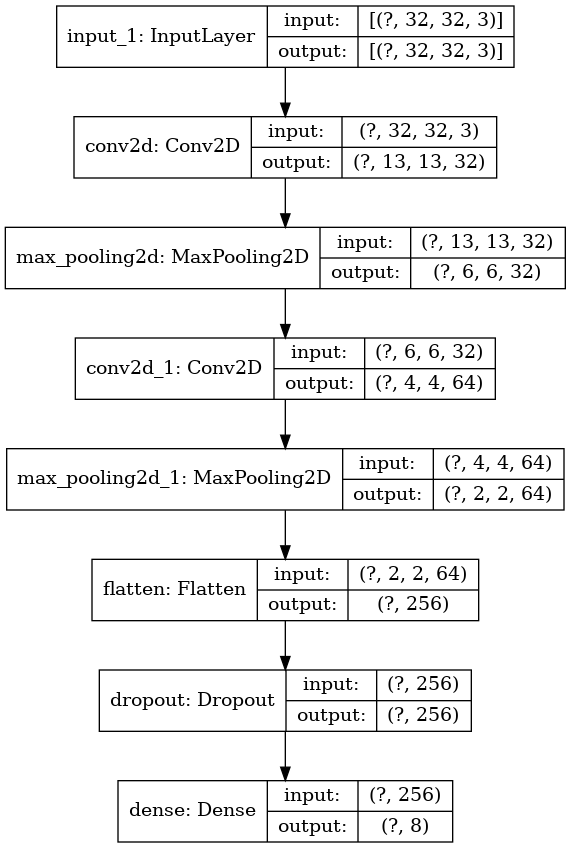

In [17]:
tf.keras.utils.plot_model(
    model_terrain,
    to_file="model_terrain.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

array([[0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

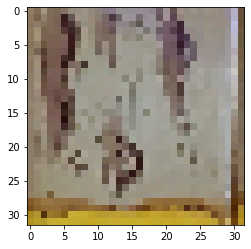

In [27]:
import matplotlib.pyplot as plt

plt.imshow(training_x[525])
np.round(model_terrain.predict(training_x[525:526]))

In [28]:
model_terrain.save("models/terrain_model.keras")

In [29]:
print("Fit model on training data")
history = model_crowns.fit(
    training_x2,
    crowns_y2,
    batch_size=1024,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(valid_x, valid_crowns_y),
)

Fit model on training data
Epoch 1/30
257/257 [==============================] - 10s 40ms/step - loss: 0.8478 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.6173 - val_sparse_categorical_accuracy: 0.7870
Epoch 2/30
257/257 [==============================] - 10s 38ms/step - loss: 0.4219 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.2596 - val_sparse_categorical_accuracy: 0.8930
Epoch 3/30
257/257 [==============================] - 10s 37ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.1406 - val_sparse_categorical_accuracy: 0.9660
Epoch 4/30
257/257 [==============================] - 10s 37ms/step - loss: 0.1566 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.0726 - val_sparse_categorical_accuracy: 0.9830
Epoch 5/30
257/257 [==============================] - 10s 38ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9920
Epoch 6/30
257/257 [==============================] - 10s 38ms/

In [30]:
predictions = model_crowns.predict(valid_x)
confusion = np.zeros((4, 4))
for i in range(valid_N):
    which = np.where( predictions[i] == np.max(predictions[i]) )[0]
    confusion[int(valid_crowns_y[i]), int(which)] += 1
    if which != valid_crowns_y[i]:
        plt.figure()
        plt.title("Mismatch in record {0}.  truth {1} and predicitons {2}".format(i, valid_crowns_y[i], which))
        plt.imshow(valid_x[i])

In [31]:
confusion

array([[714.,   0.,   0.,   0.],
       [  0., 212.,   0.,   0.],
       [  0.,   0.,  68.,   0.],
       [  0.,   0.,   0.,   6.]])

In [32]:
model_crowns.save("models/crowns_model.keras")